In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, num_pred=1, return_batch_ts = False):
        
        # Grab a random starting for each batch of data
        rand_start = np.random.rand(batch_size,1)
        
        # Convert to be on the time series
        # rand_start = Random starting point between 0-1
        # xmax - xmin - (number of steps wanted * resolution)
        # => We want to stay on the Time Serie => Not overshoot it
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create catch time serie on x axis
        batch_ts = ts_start + np.arange(0.0, steps+num_pred) * self.resolution
        
        # Create the Y data for the time serie x axis
        y_batch = np.sin(batch_ts)
        
        
        # Create the y value at time t0 and t1
        y0 = y_batch[:,:-num_pred].reshape(-1,steps,1)
        y1 = y_batch[:,num_pred:].reshape(-1,steps,1)
        
        # Create the x value at time t0 and t1
        x0 = batch_ts[:,:-num_pred].reshape(-1,steps,1)
        x1 = batch_ts[:,num_pred:].reshape(-1,steps,1)
        
        
        
        # Formating it for the RNN
        if return_batch_ts == True:
            return x0, x1, y0, y1
        else:
            return y0, y1
        

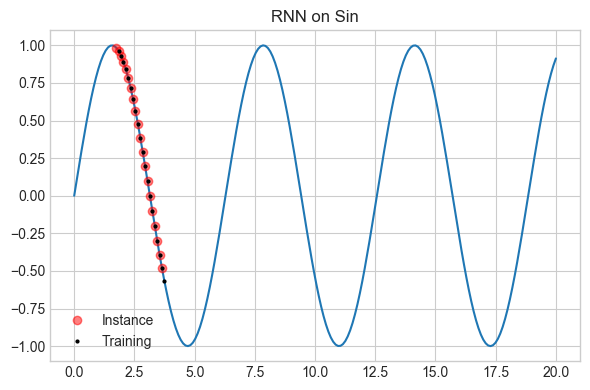

In [24]:
# Check for a random batch and plot it

ts_data = TimeSeriesData(200,0,20)

num_time_steps = 20

x0, x1, y0, y1 = ts_data.next_batch(1,num_time_steps,num_pred=1,return_batch_ts=True)


plt.figure(dpi=100)
plt.title("RNN on Sin")
plt.plot(ts_data.x_data, ts_data.y_true)
plt.plot(x0[0], y0[0], "ro", alpha=0.5, label="Instance")
plt.plot(x1[0], y1[0], "ko", markersize=2, label="Training")
plt.legend()
plt.tight_layout()

# Creating our model

In [25]:
# reset the graphs to help avoid bugs
tf.reset_default_graph()

num_input = 1

num_neurons = 120

num_output = 1

learning_rate = 0.00072

num_train_iterations = 2601

batch_size = 1

In [26]:
# Placeholders

X = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_input])

y = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_output])

In [27]:
# Creating our RNN cell layer

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.LSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_output)

In [28]:
# Runn over the loop the right number of time and return the outputs and the states

outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)

In [29]:
# Loss function => Mean Squared Error
loss = tf.reduce_mean(tf.square(outputs-y))

In [30]:
# Create the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [31]:
# Train the model
train = optimizer.minimize(loss)

In [32]:
# create the variables init
init = tf.global_variables_initializer()

In [33]:
# Before running on gpu, use this:

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

# with tf.Session(tf.ConfigProto(gpu_options)) as sess:

In [34]:
# Create a saver function

saver = tf.train.Saver()

In [35]:
# Session

with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        
        sess.run(train, feed_dict={X:X_batch, y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(f"At iteration {iteration} => MSE: {mse}\n")
    
    saver.save(sess, "./rnn_time_series_model_codealong")

At iteration 0 => MSE: 0.32090821862220764

At iteration 100 => MSE: 0.1083826795220375

At iteration 200 => MSE: 0.020862296223640442

At iteration 300 => MSE: 0.0446757897734642

At iteration 400 => MSE: 0.008746396750211716

At iteration 500 => MSE: 0.01830534264445305

At iteration 600 => MSE: 0.02256205305457115

At iteration 700 => MSE: 0.010447921231389046

At iteration 800 => MSE: 0.01040944829583168

At iteration 900 => MSE: 0.011763994581997395

At iteration 1000 => MSE: 0.007228245493024588

At iteration 1100 => MSE: 0.0029790401458740234

At iteration 1200 => MSE: 0.002773493528366089

At iteration 1300 => MSE: 0.001235622214153409

At iteration 1400 => MSE: 0.0016573199536651373

At iteration 1500 => MSE: 0.0015119505114853382

At iteration 1600 => MSE: 0.0012713687028735876

At iteration 1700 => MSE: 0.0010239440016448498

At iteration 1800 => MSE: 0.0006906907074153423

At iteration 1900 => MSE: 0.0006656261393800378

At iteration 2000 => MSE: 0.00022998657368589193

At 

In [36]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

In [37]:
# Let's now attempt to predict the time serie ont time into the future

with tf.Session() as sess:
    
    saver.restore(sess, "./rnn_time_series_model_codealong")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_input)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


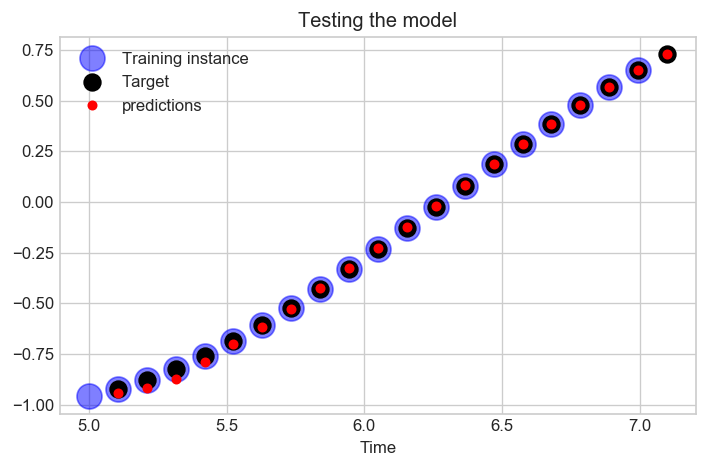

In [38]:
plt.figure(dpi=120)

plt.title("Testing the model")

# Training instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label="Training instance")

# Target To predict (correct test value => np.sin(train))
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="Target")

# Model Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="predictions")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating a new Sequence

In [39]:
with tf.Session() as sess:
    
    saver.restore(sess, "./rnn_time_series_model_codealong")
    
    # Seed zeros
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iterations in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])
        

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


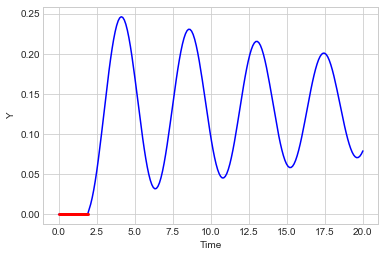

In [40]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", lw=3)
plt.xlabel("Time")
plt.ylabel("Y")

In [41]:
with tf.Session() as sess:
    
    saver.restore(sess, "./rnn_time_series_model_codealong")
    
    # Seed zeros
    training_instance = list(ts_data.y_true[:num_time_steps])
    
    for iterations in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


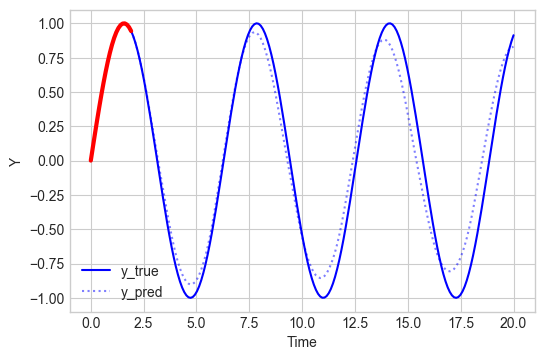

In [42]:
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(dpi=100)

plt.plot(ts_data.x_data, ts_data.y_true, "b-", label="y_true")

plt.plot(ts_data.x_data, training_instance, "b:", alpha=0.5, label="y_pred")

plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], "r", lw=3)
plt.xlabel("Time")
plt.ylabel("Y")
plt.legend()